# ROSE BAND Camp: Lets make UQ for an Optical Potential!

The purpose of this notebook is to guide you use ROSE to create a full Bayesian UQ study for an optical potential for two boty scattering, similar to what was done in: https://iopscience.iop.org/article/10.1088/1361-6471/abba72. In particular, we are studying the exact system and energy that was targeted to create the results in Figure 3 of : https://www.sciencedirect.com/science/article/pii/S0370269321007176.

We will make use of surmise for the Bayesian part, while ROSE will be in charge of creating the emulator for the two-body scattering.

In [1]:
import rose
from surmise.emulation import emulator
from surmise.calibration import calibrator

import numpy as np
import matplotlib.pyplot as plt
import time
import os

from scipy.special import spherical_jn


from scipy.stats import qmc

import scipy.stats as sps

import warnings

import corner

from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
import random



import datetime


plt.style.use('science')
plt.rcParams.update({'font.size': 12})
gr = 4
h = 3

## We define the system, the energies, and the parameters range here



In [2]:
A=40

AMU = 931.494102 # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU # MeV/c^2 PDG
MASS_P = 1.007276 * AMU # MeV/c^2 PDG
B_40CA = 342.0522 # BMEX

MASS_40CA = 20*MASS_P + 20*MASS_N - B_40CA
MU = MASS_40CA * MASS_N / (MASS_40CA + MASS_N)

energy = 20 # center-of-mass scattering energy, fixed for this example
k = np.sqrt(2*MU*energy)/rose.constants.HBARC


l_max = 10
l_list=list(range(l_max+1))


In [3]:
#Angles in where we would like to compute cross sections for plotting purposes
angles=np.linspace(1,180,180)


In [4]:
#Angles in where we would like to compute cross sections for calibration purposes (choosing it to mock an experimental
#data set up). We choose them as indices for a subset of the previous angles
anglesX=np.array(list(range(0,180,10)))

In [6]:
#Interaction

def wood_saxon(r, R, a):
    return 1/(1 + np.exp((r-R)/a))


def wood_saxon_prime(r, R, a):
    return -1/a * np.exp((r-R)/a) / (1 + np.exp((r-R)/a))**2


def optical_potential(r, theta):
    Vv, Wv, Wd, Rv, Rd, av, ad = theta
    return -Vv * wood_saxon(r, Rv, av) - \
           1j*Wv * wood_saxon(r, Rv, av) - \
           4j*ad*Wd * wood_saxon_prime(r, Rd, ad)

potential_parameters=7


#If you want to play with an optical potential of 9 parameters instead:
# def optical_potential(r, theta):
#     Vv, Wv, Wd, Rv, Rw, Rd, av, aw, ad = theta
#     return -Vv * wood_saxon(r, Rv, av) - \
#            1j*Wv * wood_saxon(r, Rw, aw) - \
#            4j*ad*Wd * wood_saxon_prime(r, Rd, ad)
# potential_parameters=9





In [7]:
#Parameters region and sampling for training. 

Vv0 = 45
Wv0 = 2
Wd0 = -7

Rv0 = 4
Rw0 = 4
Rd0 = 4

av0 = 0.6
aw0 = 0.6
ad0 = 0.6


#This is the center of our prior and around where we will train our RBM emulator
alphaCentral = np.array([Vv0, Wv0, Wd0, Rv0, Rd0, av0 , ad0])

VvKD = 46.7238
WvKD = 1.72334
WdKD= -7.2357

RvKD = 4.0538
# RwKD = 4.0538
RdKD = 4.4055

avKD = 0.6718
# awKD = 0.6718
adKD = 0.5379



#This is the value of the parameters coming from the Koning-Delaroche parametrization. Taken from https://www-nds.iaea.org/RIPL-3/
alphaKD = np.array([VvKD, WvKD, WdKD, RvKD, RdKD, avKD , adKD])

In [8]:
#Creating a scale for how much the parameters will wiggle for the emulator training. 
# Afterwards we sample from a latin hyper cube for training, but use this scales also for
# the testing sampling which we do it with a Gaussian
scaleTraining=0.2

bounds_Vv_Scale = abs(Vv0*(scaleTraining))
bounds_Wv_Scale = abs(Wv0*(scaleTraining))
bounds_Wd_Scale = abs(Wd0*(scaleTraining))

bounds_Rv_Scale = abs(Rv0*(scaleTraining))
# bounds_Rw_Scale = abs(Rw0*(scaleTraining))
bounds_Rd_Scale = abs(Rd0*(scaleTraining))

bounds_av_Scale = abs(av0*(scaleTraining))
# bounds_aw_Scale = abs(aw0*(scaleTraining))
bounds_ad_Scale = abs(ad0*(scaleTraining))




bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]
bounds_Wv = [Wv0-bounds_Wv_Scale, Wv0+bounds_Wv_Scale]
bounds_Wd = [Wd0-bounds_Wd_Scale, Wd0+bounds_Wd_Scale]

bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]
# bounds_Rw = [Rw0-bounds_Rw_Scale, Rw0+bounds_Rw_Scale]
bounds_Rd = [Rd0-bounds_Rd_Scale, Rd0+bounds_Rd_Scale]

bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]
# bounds_aw = [aw0-bounds_aw_Scale, aw0+bounds_aw_Scale]
bounds_ad = [ad0-bounds_ad_Scale, ad0+bounds_ad_Scale]


bounds = np.array([
    
    bounds_Vv,
    bounds_Wv,
    bounds_Wd,
    
    bounds_Rv,
#     bounds_Rw,
    bounds_Rd,
    
    bounds_av,
#     bounds_aw,
    bounds_ad
    
])


In [19]:
#Lets define how many training samples we want to use for our reduced basis. For the first round, we limit to 50 to go fast,
#but you could try with more!

n_train=50


sampler = qmc.LatinHypercube(d=len(bounds), seed=142857)

sample = sampler.random(n_train)
train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

np.savetxt("train_params.txt",train)

In [9]:
#Training the Empirical Interpolation Method is way cheaper, since we have the form of the potential explicitely.
#That is why we use 1,000 samples here

n_train_EIM=1000


sampler = qmc.LatinHypercube(d=len(bounds), seed=142857)

sample = sampler.random(n_train_EIM)
train_EIM = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
np.savetxt("train_params_EIM.txt",train_EIM)

In [10]:
#The following test parameters will be used for the CAT plot
n_test=50


sampler = qmc.LatinHypercube(d=len(bounds), seed=142857)

sample = sampler.random(n_test)
test_params = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
np.savetxt("test_params.txt",test_params)

In [11]:
#We define the interaction to use, in this case, the optical potential 
interaction=rose.Interaction(
        optical_potential,
        7,
        MU,
        energy,
    is_complex = True,
    )



In [12]:
# This is the high fidelity solver we will use to get the wave functions for training our RBM.
#The tolerances control the precision of the high fidelity solver (which uses a Runge-Kuta method).
#The smaller these numbers, the more precise it will be but the longer it will take to compute solutions 
HF_solver=rose.SchroedingerEquation(
        interaction,
        hifi_tolerances=[1e-9, 1e-9]
    ) 

In [13]:
#Defining our scaled "radial" coordinate
rho = rose.constants.DEFAULT_RHO_MESH.copy()

In [14]:
#In the following we train a "dummy" emulator that will serve as our high fidelity amplitude calculator.
#We don't directly use the HF_solver in the previous lines in this version of ROSE. The updated one 
#will have full access to cross sections and amplitudes on the HF_solver side.


warnings.filterwarnings("ignore", category=RuntimeWarning)
n_trainSmall=3

sampler = qmc.LatinHypercube(d=len(bounds), seed=142857)

sample = sampler.random(n_trainSmall)
trainSMALL = qmc.scale(sample, bounds[:, 0], bounds[:, 1])



In [15]:

%%time
saeExact = rose.ScatteringAmplitudeEmulator.from_train(
    interaction,
    trainSMALL,
    l_max,
    n_basis = 2,
    angles = angles/180*np.pi,
    hf_tols=[10**(-9),10**(-9)]
)


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.93it/s]


CPU times: user 7.62 s, sys: 8.07 s, total: 15.7 s
Wall time: 4.39 s


In [16]:
#Now we calculated the exact amplitude (and cross section) for the test parameters we have

test_CS=[]
for params in tqdm(test_params):
    testval=saeExact.exact(params)
    test_CS.append(10*np.conj(testval)*testval)
np.savetxt("test_CS.txt",test_CS)



test_CS=np.loadtxt("test_CS.txt",dtype=np.complex_)


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.24s/it]


In [ ]:
#Lets plot these cross sections to see how they look. In principle, since our parameters are around the
# Koning-Delaroche parametrization they should all be relatively similar to
#figure 3 of https://www.sciencedirect.com/science/article/pii/S0370269321007176

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')



for i in range(50):
    ax.plot(angles, test_CS[i])
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\sigma/d\Omega$ (mb)');

In [17]:
#Here we create the high fidelity solutions (wave functions) we will use to train our emulator. They are stored
# as pickled objects so we don't have to solve the high fidelity solutions every time for each new emulator

In [20]:
%%time
phis_list=[]
for l in tqdm(l_list):
    phis = np.array([HF_solver.phi(energy,alpha, rho, l) for alpha in train], dtype=np.complex128)
    np.save(f'hf_phis_train_energy_l_{l}.npy',
        np.vstack((rho, phis)))
    phis_list.append(phis)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.16s/it]

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [21]:
files = list(filter(lambda f: 'hf_phis_train' in f, os.listdir()))

In [22]:
#The following function trains a ROSE emulator for a given configuration of [n_basis_wave-functions,m_basis_EIM].
#See how rho0 is created by the free solution, and the reduced basis is created by the first n_basis principal
#components of the deviations from the free solution

def emulator_trainer(Sae_config):
    
    opLoop = rose.InteractionEIM(
    optical_potential,
    7,
    MU,
    energy,
    train_EIM,
    is_complex = True,
    explicit_training = True,
    n_basis = Sae_config[1])
    
    
    bases = []
   #Building the basis# 
   ################### 
    for l in l_list:
        file_l = list(filter(lambda f: f'l_{l}' in f, files))
        data = np.load(file_l[0])
        rho = data[0].real
        phi_0 = np.array([z*spherical_jn(l, z) for z in rho], dtype=np.float64)
        phis = data[1:]
        
        basis = rose.CustomBasis(
            phis.T,
            phi_0,
            rho,
            Sae_config[0],
            l,
            use_svd=True
        )
        bases.append(basis)

   ################### 
    
    return rose.ScatteringAmplitudeEmulator(opLoop, bases, l_max,angles=angles/180*np.pi)

    

In [25]:
#Try creating some configurations for the RB emulator and for the HF solver for the CAT plot. Below are some suggestions
# from what we have used

Sae_configs=\
# [[3,3],
# [8,14],
# [14,8],
# [14,14],
# [18,18]]


HF_configs=\
# [-1.0,-2,-3,-5,-7]

In [27]:
#Once the configurations have been decided, the following two cells will create the emulators and high fidelity solvers

Sae_Emulators={}

for saeconfig in tqdm(Sae_configs):
    key = f'sae_{saeconfig[0]}_{saeconfig[1]}'
    Sae_Emulators[key]=emulator_trainer(saeconfig)
    

    
#The following will save the emulators locally, but it can take up a bit of space so we are commeting it out.
# for saeconfig in tqdm(Sae_configs):
#     key = f'sae_{saeconfig[0]}_{saeconfig[1]}'
#     Sae_Emulators[key].save(f'sae_n_{saeconfig[0]}_m_{saeconfig[1]}.pkl')
    



100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


In [28]:
HF_Solvers={}

for HFconfig in HF_configs:
    key = f'HF_{-HFconfig}'
    HF_Solvers[key]=rose.ScatteringAmplitudeEmulator.from_train(
    interaction,
    trainSMALL,
    l_max,
    n_basis = 2,
    angles = angles/180*np.pi,
    hf_tols=[10**(HFconfig),10**(HFconfig)])
    
    
# for HFconfig in tqdm(HF_configs):
#     key = f'HF_{-HFconfig}'
#     HF_Solvers[key].save(f'Exact_tol_{-HFconfig}.pkl')


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


In [29]:
#If they were stored, the following lines can be used to load the emulators and HF solvers

# Sae_Emulators={}

# for saeconfig in tqdm(Sae_configs):
#     key = f'sae_{saeconfig[0]}_{saeconfig[1]}'
#     Sae_Emulators[key]=rose.ScatteringAmplitudeEmulator.load(f'sae_n_{saeconfig[0]}_m_{saeconfig[1]}.pkl')


# HF_Solvers={}

# for HFconfig in tqdm(HF_configs):
#     key = f'HF_{-HFconfig}'
#     HF_Solvers[key]=rose.ScatteringAmplitudeEmulator.load(f'Exact_tol_{-HFconfig}.pkl')


In [30]:
#This function creates the data necessary to make a CAT plot, while the two next cells create the data for emulators and HF

def CAT_Data_Maker(CS_calculator,test_parameters,test_data):

    #Both the predictions and the test_data are evaluated at the [anglesX] of interest
    
    prediction_list=[]
    times_list=[]
    for i in range(len(test_parameters)):
        st = time.time()
        predicted=CS_calculator(test_parameters[i])[anglesX]
        et = time.time()
        prediction_list.append(abs(10*np.conj(predicted)*predicted))
        times_list.append(et-st)
        
    residual_list=[]
    residual_list_median=[]
    for i in range(len(test_parameters)):
        
        residual_list.append(np.real(abs((prediction_list[i]-test_data[i][anglesX]))\
                                     /(test_data[i][anglesX])))
        residual_list_median.append(np.median(residual_list[i]))
        
    return [times_list,residual_list_median,residual_list,prediction_list]
        

In [31]:
CAT_Emulator_Data={}

for sae in tqdm(Sae_Emulators):
    
    CAT_Data=CAT_Data_Maker(Sae_Emulators[sae].predict,test_params,test_CS)
    
    CAT_Emulator_Data[sae]={'times':CAT_Data[0],'median_residuals':CAT_Data[1],'residuals_list':CAT_Data[2],
                                    'full_predictions':CAT_Data[3]}

    



100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.58it/s]


In [32]:
CAT_HF_Data={}

for HF in tqdm(HF_Solvers):
    
    CAT_Data=CAT_Data_Maker(HF_Solvers[HF].exact,test_params,test_CS)
    
    CAT_HF_Data[HF]={'times':CAT_Data[0],'median_residuals':CAT_Data[1],'residuals_list':CAT_Data[2],
                                    'full_predictions':CAT_Data[3]}

    



100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


In [33]:
#These are some colors I really like :) 

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [ ]:
#Writing this took some time, you don't have to go into much detail on it, just click go and it should make the CAT plot

#The only important input is what would your targets for speed and accuracy be. We put 1% for the accuracy goal and
#1 million samples per hour, but you can select different goals

accuracy_goal=0.01
time_goal=0.036

fig, ax = plt.subplots(figsize=(15,7),dpi=400)


custom_lines = []

custom_lines.append(Line2D([], [], color='w', marker='X', linestyle='None',
                          markersize=20, label='[$n_\phi$, $n_U$]'))

level_sns=0.05



i=0
for sae in Sae_Emulators:

    data_sae=[

        np.array([np.full(len(angles[anglesX]), j) for j in CAT_Emulator_Data[sae]['times']]).flatten(),
        np.array(CAT_Emulator_Data[sae]['residuals_list']).flatten()]
    data_sae=np.array(data_sae)

    
    sns.kdeplot(x=data_sae[0], y=data_sae[1],levels=[level_sns,1],color=colors[i],log_scale=[True,True],fill=True,alpha=0.6)
    
    sns.kdeplot(x=data_sae[0], y=data_sae[1],levels=[level_sns],color=colors[i],log_scale=[True,True],
                linewidths=3,linestyles='dashed')
    ax.scatter(data_sae[0],data_sae[1],s=5,color=colors[i])
    
    custom_lines.append(Line2D([], [], color=colors[i], marker='o', linestyle='None',
                          markersize=20, label=str(Sae_configs[i])))
    

    i=i+1


    
    
    
    
    
i=0
for HF in HF_Solvers:

    data_hf=[np.array([np.full(len(angles[anglesX]), j) for j in CAT_HF_Data[HF]['times']]).flatten(),
             np.array(CAT_HF_Data[HF]['residuals_list']).flatten()]
    
    data_hf=np.array(data_hf)
    
    
    
    sns.kdeplot(x=data_hf[0], y=data_hf[1],levels=[level_sns,1],color='b',log_scale=[True,True],fill=True,alpha=0.6)
    
    sns.kdeplot(x=data_hf[0], y=data_hf[1],levels=[level_sns],color='b',log_scale=[True,True],
                linewidths=3,linestyles='dashed')
    ax.scatter(data_hf[0],data_hf[1],s=5,color='b')
    


    i=i+1

    
custom_lines.append(Line2D([], [], color='b', marker='o', linestyle='None',
                           markersize=20, label='RK-45'))
ax.legend(handles=custom_lines,fontsize=22,frameon=True, edgecolor='black') 
    
ax.plot([10**(-4),time_goal],[accuracy_goal,accuracy_goal], color='k', linewidth=1,linestyle='dashed')
    
    
ax.plot([time_goal,time_goal],[10**(-9),accuracy_goal], color='k', linewidth=1,linestyle='dashed')  
    
    
    
    

ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel('Time (s)',fontsize=23)
ax.set_ylabel('Median Relative error Diff. Cross Sec. ',fontsize=23)


plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)

plt.xlim(2*10**(-4), 3*10**(0))
plt.ylim(10**(-8), 10**(1))

# show the plot
plt.show()

# Going Bayesian with surmise!

In [44]:
#We should select the emulator that gave the optimal tradeoff for our purposes. Bellow is an example of what we chose
#before, the 14-14 configuration
saeMCMC = 
# saeMCMC = Sae_Emulators['sae_14_14']

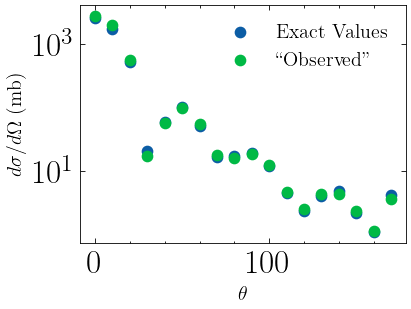

In [45]:
#The following lines create the data we will use to fit our model. We assume 10% error in the cross sections
#and plot the true values and the "observed" ones, those that were fluctuated by 10%

alphatarget=alphaKD
#The target parameter, this will generate the data

anglesindexs=anglesX

f_exact = saeExact.exact(alphatarget)


X = np.array(anglesindexs)

yperfect = np.real(10*np.conj(f_exact[X])*f_exact[X])

yerr = yperfect*0.1

np.random.seed(142857)

y=[]

for i in range(len(yperfect)):
    y.append(yperfect[i]+np.random.normal(0, yerr[i]))

y=np.array(y)

fig, ax = plt.subplots(dpi=120)
fig.patch.set_facecolor('white')



ax.scatter(anglesX, yperfect, label='Exact Values')
ax.scatter(anglesX, y, label ='``Observed"')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\sigma/d\Omega$ (mb)');

## Specifying the prior:

In [47]:
#In this default we are assuming uncorrelated Gaussian priors. 

#Specifying the priors
alphaCentralPrior= [45, 1.5,-7.0,  4.0,4.0,  0.6,0.6]

SigmasPrior= [abs(boundval * 0.5) for boundval in alphaCentralPrior]




#We use a smaller scale for the starting values of the MCMC chains so that we minimize the chances of one
#starting in a negative value of the diffuseness or the radii
MCMCScale= [abs(boundval * 0.1) for boundval in alphaCentralPrior]


In [48]:
#This cell specifies the configuration for the Monte Carlo sampling with surmise. You could play by changing the
#number of chains, the number of samples per chain, the step size or the burning in samples. 

StepSizes0=0.004*np.abs(np.array([Vv0,5*Wv0, Wd0, Rv0,Rd0, av0, ad0]))
numsamp = 5000
total_chains=5
# numcores=12
BurnSamples0=500

In [49]:
#We define all the functions surmise needs

class prior_scattering:
    """ This defines the class instance of priors provided to the method. """


    def lpdf(theta):
        
        total_prior_pdf=sps.norm.logpdf(theta[:, 0], alphaCentralPrior[0],SigmasPrior[0] )
        
        for i in range(1,len(alphaCentralPrior)):
            total_prior_pdf=total_prior_pdf+ sps.norm.logpdf(theta[:, i], alphaCentralPrior[i],SigmasPrior[i] )
            
            
            
        return (total_prior_pdf).reshape((len(theta), 1))


    def rnd(n):
        totalRandomSamples=[]
        for i in range(len(alphaCentralPrior)):
            totalRandomSamples.append(sps.norm.rvs( alphaCentralPrior[i], MCMCScale[i],   size=n))
        
        totalRandomSamplesNumpy=np.array(totalRandomSamples)
        
        return totalRandomSamplesNumpy.T
        
        
        
        
    
def rbm_emulator(x,theta):
    yList=[]
    for i in range(len(theta)):
        AmplitudeEm=saeMCMC.predict(theta[i])
        yList.append(10*np.real(np.conj(AmplitudeEm[x])*AmplitudeEm[x]))
        notfinite = np.logical_not(np.isfinite(10*np.real(np.conj(AmplitudeEm[x])*AmplitudeEm[x])))
        if(np.any(notfinite)):
            print("Not finite :(. For theta: ",theta[i])
            print("Bad boy was: ",yList[i])
    return np.array(yList).T

    
    
def calibration_runner(rbm,x,y,obsvar,test_params,numsamp,i,caldir):
   
    cal = calibrator(emu=rbm,
                   y=y,
                   x=x,
                   thetaprior=prior_scattering, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                        'theta0': test_params.reshape(1,7),
                        'sampler': 'metropolis_hastings',
                         'numsamp' : numsamp,
                         'stepType' : 'normal',
                         'stepParam' : StepSizes0,
                        'burnSamples' : BurnSamples0
                   })
                       
 
    calfile = os.path.join(caldir,"caltheta_{}.out".format(i))
    np.savetxt(calfile,cal.info['thetarnd'])

    return cal.info['thetarnd']

In [50]:
nParams=7

In [51]:
#Create the directory and the obs variance for surmise

random.seed(142857)

obsvar = np.maximum(1.0*np.square(yerr),1e-5)

caldir = os.path.join(os.getcwd(), "Cal-"+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
os.makedirs(caldir, exist_ok=True)

rand_params=prior_scattering.rnd(total_chains)

In [52]:
# Run the calibration and print the total time it took, in seconds

rbm = emulator(x=X, theta=alphaCentralPrior, passthroughfunc=rbm_emulator)
st = time.time()
all_chains=calibration_runner(rbm,X,y,obsvar,rand_params[0],numsamp,0,caldir)

for ij in range(total_chains-1):
    
    current_cal=calibration_runner(rbm,X,y,obsvar,rand_params[ij],numsamp,ij+1,caldir)
    
    all_chains = np.vstack((all_chains,current_cal,))
    
    print("Percentage Completed ",int((ij+1)/(total_chains-1)*100))
    
et = time.time() 
print("Total time:", et-st)

  

Final Acceptance Rate:  0.5202
Final Acceptance Rate:  0.5112
Percentage Completed  25
Final Acceptance Rate:  0.5282
Percentage Completed  50
Final Acceptance Rate:  0.51
Percentage Completed  75
Final Acceptance Rate:  0.5284
Percentage Completed  100
Total time: 49.36478400230408


# Plotting the results of the calibration

In [ ]:
#The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
#size for the ticks to be correct

#The red marks show the exact values that we are trying to recover, in this case the KD parametrization
    
figure = corner.corner(all_chains,
    labels=['$V_v$','$W_v$','$W_d$','$R_v$','$R_d$','$a_v$','$a_d$'],
    labelpad=0.2,
                       bins=20,
    label_kwargs={"fontsize":50},
                      hist_kwargs= {"linewidth":3},
    quantiles=None,
                       truths=alphaKD, truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 24
height = 18
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=30)    
plt.rc('ytick', labelsize=30)


In [ ]:
#Lets check how the chains look like

labelsChains=['$V_v$','$W_v$','$W_d$','$R_v$','$R_d$','$a_v$','$a_d$']XAll=np.arange(len(angles))
fig, axs = plt.subplots(nParams, 1, figsize=(12, 12))

for i in range(nParams):
    axs[i].plot(all_chains.T[i])
    axs[i].set_ylabel(labelsChains[i],fontsize=18);

plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15)
plt.show()

## Plotting our final calibrated model alongside the "data"

In [53]:

XAll=np.arange(len(angles))

#In the next cell we sample 10000 values from our visited posterior to make the final plot

In [54]:
%%time
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains,(10000),replace=False)
rndm_m = rbm_emulator(XAll, theta_rand).T

CPU times: user 29.7 s, sys: 56.4 s, total: 1min 26s
Wall time: 10.8 s


In [ ]:
fig, naxs = plt.subplots(1, 1, figsize=(20, 10))
median = np.percentile(rndm_m, 50, axis = 0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis = 0))

lower = np.abs(np.percentile(rndm_m, 2.5, axis = 0))

naxs.plot(angles, median, color='C0')
naxs.fill_between(angles, lower, upper, color='C0', alpha=0.5)

naxs.scatter(anglesX, yperfect,s=100,c='r')
naxs.errorbar(anglesX,yperfect, yerr=2*yerr, fmt="o",c='r')

naxs.set_yscale('log')

naxs.set_xlabel(r'$\theta$ (deg)',fontsize=50)
naxs.set_ylabel(r'$d\sigma/d\Omega$ [mb/sr] ',fontsize=50);

plt.text(100,300, r'$^{40}\text{Ca}(n,n)$', fontsize=100)


plt.rc('xtick', labelsize=50)    # fontsize of the tick labels
plt.rc('ytick', labelsize=50)


plt.show()

In [52]:
et_super=time.time()

print((et_super-st_super)/60)

3.815669059753418
